In [1]:
# Importing the needed modules:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import cv2                
import numpy as np         
import os                  
from random import shuffle 
from tqdm import tqdm  #to make a nice loading bar
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [0]:
# The directories where I saved the clothes male and female images:
TRAIN_DIR_male =  "/content/drive/My Drive/CS156_Images/male2/"
TRAIN_DIR_female = "/content/drive/My Drive/CS156_Images/female2/"
IMG_SIZE = 224 

In [0]:
# A function to upload images and turn them into arrays and also create labels for them
def create_train_data(dirr, label):
    training_data = []
    labels = []
    for img in tqdm(os.listdir(dirr)):
        labels.append(label)
        path = os.path.join(dirr,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        training_data.append(np.array(img))
    shuffle(training_data)
    return np.array(training_data), labels

In [4]:
# male clothes images
data_male, male_labels = create_train_data(TRAIN_DIR_male, 'male')

100%|██████████| 935/935 [00:06<00:00, 135.46it/s]


In [5]:
# female clothes images
data_female, female_labels = create_train_data(TRAIN_DIR_female, 'female')

100%|██████████| 1095/1095 [00:08<00:00, 130.08it/s]


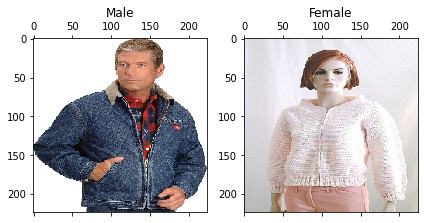

In [6]:
#visualizing images:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.matshow(data_male[2])
plt.title('Male', y=1.09)

ax2 = fig.add_subplot(1,2,2)
ax2.matshow(data_female[5])
plt.title('Female',y=1.09)


plt.tight_layout()
plt.show()

In [0]:
all_data = np.concatenate([data_male, data_female]) # adding all the images in one array
all_data_labels = np.concatenate([male_labels, female_labels])

In [0]:
#splitting my data randomly
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data_labels, test_size=0.3, random_state=0)

In [0]:
X_train_reshaped = X_train.reshape(len(X_train), -1)
X_test_reshaped = X_test.reshape(len(X_test), -1)

In [10]:
## Training a Support Vector Classifier with a Linear Kernel:

SVC_linear = SVC(kernel = 'linear')
SVC_linear.fit(X_train_reshaped, y_train)

#Testing the model on the test dataset
linear_predicted_y = SVC_linear.predict(X_test_reshaped)
print("Linear Accuracy:", accuracy_score(y_test, linear_predicted_y))

Linear Accuracy: 0.6108374384236454


In [11]:
## Training a Support Vector Classifier with a RBF Kernel:

SVC_rbf = SVC(kernel = 'rbf')
SVC_rbf.fit(X_train_reshaped, y_train)

#Testing the model on the test dataset
rbf_predicted_y = SVC_rbf.predict(X_test_reshaped)
print("RBF Accuracy:", accuracy_score(y_test, rbf_predicted_y))

RBF Accuracy: 0.6633825944170771


In [12]:
## Training a Support Vector Classifier with a poly Kernel with degree 2:

poly_rbf = SVC(kernel = 'poly', degree=2)
poly_rbf.fit(X_train_reshaped, y_train)

#Testing the model on the test dataset
poly_predicted_y = poly_rbf.predict(X_test_reshaped)
print("poly Accuracy:", accuracy_score(y_test, poly_predicted_y))

poly Accuracy: 0.6486042692939245


I'm going to import the VGG16 model, I will use that model to extract features of the images, which should turn images into a btter and easier to classify representation. I will then train a support vector classifer on these representation and evaluate that model on the test dataset.

In [13]:
# Importing the VGG16 network
VGG16_model = VGG16(weights='imagenet', include_top=False)

# Extracting the features for the training dataset:
X_train_input = preprocess_input(X_train) 
train_features = VGG16_model.predict(X_train_input)
train_features = train_features.reshape(len(train_features), -1)

#training a SVC on the extracted features:
SVC_rbf = SVC(kernel = 'rbf')
SVC_rbf.fit(train_features, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# After I trained the model, I will evaluate it on the test dataset:
X_test_input = preprocess_input(X_test)
test_features = VGG16_model.predict(X_test_input)
test_features = test_features.reshape(len(test_features), -1)

In [15]:
VGG16_SVC_predict_test = SVC_rbf.predict(test_features)
print("VGG16_SVC Accuracy: ", accuracy_score(VGG16_SVC_predict_test, y_test))

VGG16_SVC Accuracy:  0.8308702791461412


## Conclusion
The support vector classifers scored an accuracy that was around 66% while the support vector classifier trained with features from VGG16 scored an accuracy of 83%. This is a signficant improvement in the accuracy that is due to the fact that the model VGG16 has been trained on a much larger dataset and hence it should be able to do a good job at predictions. Both SVC and the neural network are supervised machine learning classifers. The neural network model is a paramteric classifer that uses hyper-paramters tuning during training, it uses loss functions (cross entropy or maximum likelhood) in order to optimize these paramters (using gradient decsent methods). SVC, however, is a non-paramteric classifier that depends on projecting the data to higher dimensions using kernels (while most of the time it depends on the kernel trick to avoid the time cost of mapping to higher dimensions). It's hard to say which model is better and I personally think that no model is better than the other in general but it always depends on the application. While SVC have the advantage that they are able to reach the global optimum, less prone to fitting, takes less memory, neural netowork have the advantage of being extremely flexible in learning the important features due to its structure that consists of many hidder layers that can be easily adjusted depenging on the application.